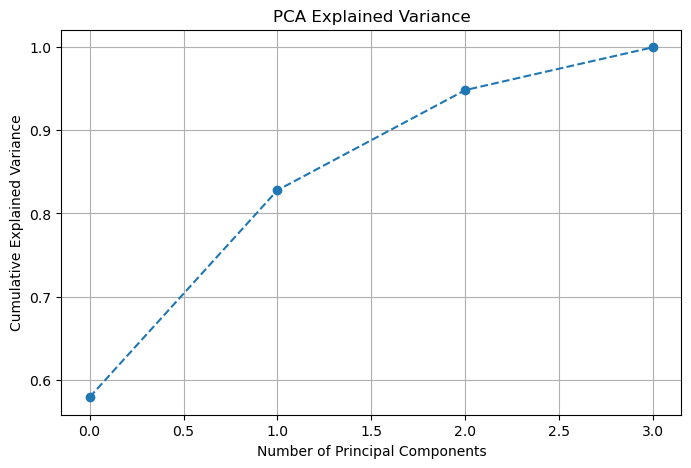

Number of principal Components Selected: 4
Best SVR Parameters: {'kernel': 'rbf', 'gamma': 1, 'epsilon': 0.2, 'C': 100}
SVR Perfomance:
Mean Absolute Error: 31.828644765093838
Root Mean Squared Error: 45.75019977005572
R2 Score: 0.6903297747657058


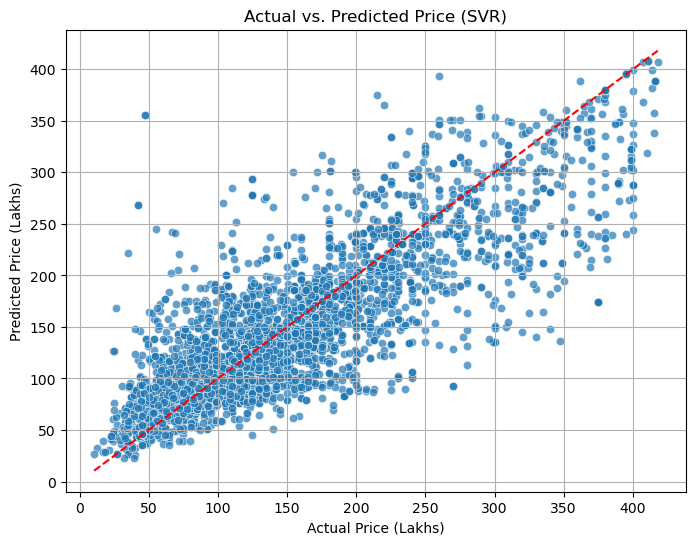

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df = pd.read_csv('Cleared_Quickr.csv')


df.drop(columns=['Unnamed: 0'], inplace=True)

# Detect and remove outliers using IQR method

Q1 = df["Price (Lakhs)"].quantile(0.25)
Q3 = df["Price (Lakhs)"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df["Price (Lakhs)"] >= lower_bound) & (df["Price (Lakhs)"] <= upper_bound)]


# Separate features and target variable
X = df.drop(columns=["Price (Lakhs)"])
y = df["Price (Lakhs)"]

# Standardized features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (keeping 99% variance)
pca = PCA(n_components =0.99)
X_pca = pca.fit_transform(X_scaled)


# Plot explained variance
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.show()


print(f"Number of principal Components Selected: {X_pca.shape[1]}")


# Train-test split
X_train , X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


# Optimize SVR using RandomizedSearchCV

param_dist = {
    'C':[0.1,1,10,100],
    "gamma":["scale", 0.01,0.1,1],
    "epsilon":[0.01, 0.1, 0.2, 0.5],
    "kernel":["rbf", "linear"]
}


svr = SVR()
random_search = RandomizedSearchCV(svr, param_distributions= param_dist, n_iter= 20, cv= 5, scoring='r2', n_jobs=-1)
random_search.fit(X_train, y_train)


print("Best SVR Parameters:", random_search.best_params_)

# Train SVR with best parameters
best_svr = SVR(**random_search.best_params_)
best_svr.fit(X_train, y_train)

# Predict on test data

y_pred_svr = best_svr.predict(X_test)


# Evaluate SVR Model
mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)


print("SVR Perfomance:")
print("Mean Absolute Error:",mae_svr)
print("Root Mean Squared Error:",rmse_svr)
print("R2 Score:",r2_svr)

#Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_svr, alpha=0.7)
plt.xlabel("Actual Price (Lakhs)")
plt.ylabel("Predicted Price (Lakhs)")
plt.title("Actual vs. Predicted Price (SVR)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.grid()
plt.show()




In [4]:
r2_svr

0.6874770333523652